In [70]:
! ls

LICENSE               plots/                test_20_30_small.h5
Makefile              references/           test_JetTPredict.txt
README.md             reports/              test_environment.py
docs/                 requirements.txt      tmp_test_output /
models/               setup.py              tox.ini
notebooks/            src/


In [1]:
""" 
The full evaluation pipeline for JJEPA.
1. Plot training and validation losses for the trained model.
2. Generate histograms for the learned representations using PCA.
4. Generate t-SNE plots for the learned representations.
"""

# load standard python modules
import argparse
from datetime import datetime
import copy
import sys
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import tqdm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pathlib import Path

# load torch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from src.models.jjepa import JJEPA
from src.options import Options
from src.dataset.JetDataset import JetDataset

In [6]:
def load_data(dataset_path):
    # data_dir = f"{dataset_path}/{flag}/processed/4_features"
    datset = JetDataset(dataset_path, labels=True)
    dataloader = DataLoader(datset, batch_size=len(datset), shuffle=False)
    x, _, _, _, subjet_mask, _, labels = next(iter(dataloader))
    x = x.view(x.shape[0], x.shape[1], -1)
    print(f"Loaded jets {x.shape}")
    print(f"Loaded labels {labels.shape}")
    print(f"Loaded subjet_mask {subjet_mask.shape}")
    return x, labels

In [8]:
def load_data(dataset_path):
    # data_dir = f"{dataset_path}/{flag}/processed/4_features"
    datset = JetDataset(dataset_path, labels=True)
    dataloader = DataLoader(datset, batch_size=args.batch_size, shuffle=False)
    return dataloader

In [7]:
particles, labels = load_data("test_20_30_small.h5")

Initializing JetDataset with file: test_20_30_small.h5
Loading features and subjets from HDF5 file
Filtered to 6458 good jets
Final dataset size: 6458 jets
__getitem__ returns (x, particle_features, subjets, indices, subjet_mask, particle_mask, labels)
Loaded jets torch.Size([6458, 20, 120])
Loaded labels torch.Size([6458])
Loaded subjet_mask torch.Size([6458, 20])


In [10]:
import argparse
import os

parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])
args.device = "cpu"
args.batch_size = 32
args.eval_path = "evaluations"
os.makedirs(args.eval_path, exist_ok=True)
dataloader = load_data("test_20_30_small.h5")

Initializing JetDataset with file: test_20_30_small.h5
Loading features and subjets from HDF5 file
Filtered to 6458 good jets
Final dataset size: 6458 jets
__getitem__ returns (x, particle_features, subjets, indices, subjet_mask, particle_mask, labels)


In [11]:
def obtain_reps(net, dataloader, args):
    with torch.no_grad():
        net.eval()
        all_reps = []
        pbar = tqdm.tqdm(dataloader)
        for i, (x, _, subjets, _, subjet_mask, _, labels) in enumerate(pbar):
            x = x.view(x.shape[0], x.shape[1], -1)
            batch = {"particles": x.to(torch.float32)}
            reps = net(
                batch,
                subjet_mask.to(args.device),
                subjets_meta=subjets.to(args.device),
                split_mask=None,
            )
            all_reps.append(reps)
            pbar.set_description(f"{i}")
        all_reps = torch.concatenate(all_reps)
        # all_reps = all_reps.view(all_reps.shape[0], -1)
        all_reps = all_reps.sum(dim=1)
        print(all_reps.shape)
    return all_reps

In [13]:
data_test = obtain_reps(context_encoder, dataloader, args)

201: 100%|██████████| 202/202 [00:43<00:00,  4.68it/s]


torch.Size([6458, 1024])


In [4]:
def load_model(model_path=None, device="cpu"):
    options = Options("src/test_options.json")
    model = JJEPA(options).to(device)
    if model_path:
        model.load_state_dict(torch.load(model_path, map_location=device))
    print(model)
    return model

In [12]:
model = load_model()
context_encoder = model.context_transformer

JJEPA(
  (context_transformer): JetsTransformer(
    (subjet_emb): EmbeddingStack(
      (embedding_layers): ModuleList(
        (0): BasicBlock(
          (linear): Linear(in_features=120, out_features=256, bias=True)
          (activation): GELU(approximate='none')
          (normalization): LayerNorm(
            (normalization): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          )
          (dropout): Identity()
          (residual): Identity()
        )
        (1): BasicBlock(
          (linear): Linear(in_features=256, out_features=512, bias=True)
          (activation): GELU(approximate='none')
          (normalization): LayerNorm(
            (normalization): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          )
          (dropout): Identity()
          (residual): Linear(in_features=256, out_features=512, bias=True)
        )
        (2): BasicBlock(
          (linear): Linear(in_features=512, out_features=1024, bias=True)
          (activation): GELU

In [35]:
test_loader = DataLoader(particles, 32)
ctxt_reps = []
pbar = tqdm.tqdm(test_loader)
for i, batch in enumerate(pbar):
    batch = {"particles": batch.to(torch.float32)}
    reps = context_encoder(batch, torch.ones((batch['particles'].shape[0], 1)), subjets_meta=None, split_mask=None)
    ctxt_reps.append(reps)


100%|██████████| 202/202 [00:05<00:00, 37.90it/s]


In [36]:
ctxt_reps = torch.concatenate(ctxt_reps)
ctxt_reps = ctxt_reps.view(ctxt_reps.shape[0], -1)

/Users/zhaozihan/.pyenv/versions/3.11.8/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


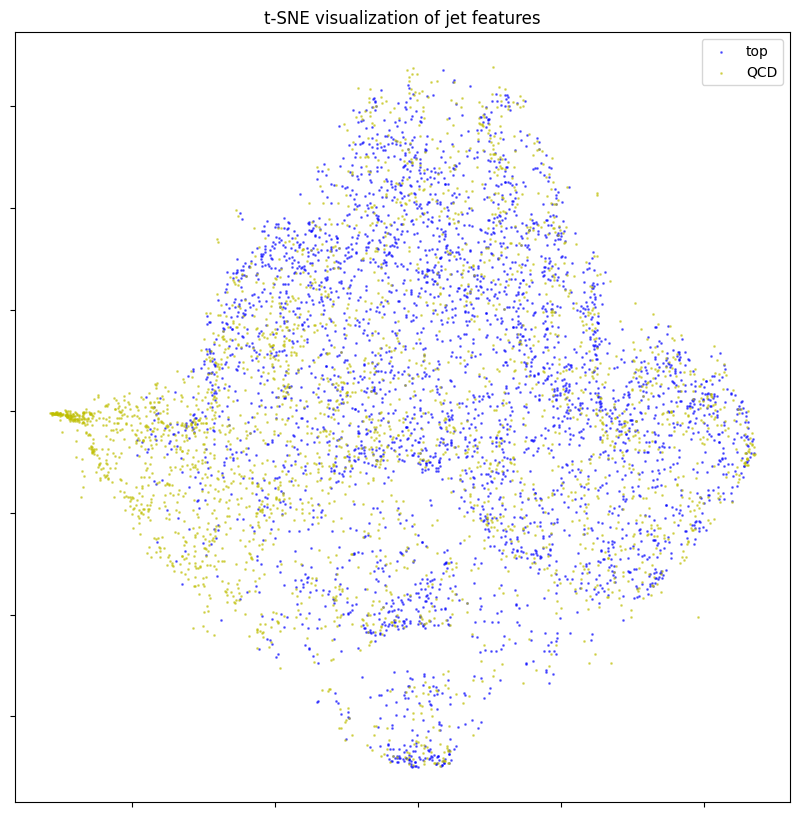

In [38]:
data_test = ctxt_reps
data_numpy = data_test.detach().to("cpu").numpy()
data_numpy.shape

# Apply t-SNE
tsne = TSNE(
    n_components=2, perplexity=30, n_iter=300
)  # you can change these hyperparameters as needed
tsne_results = tsne.fit_transform(data_numpy)

# tsne_results now has a shape of [num_samples, 2], and you can plot it

labels_numpy = labels
# Use boolean indexing to separate points for each label
top_points = tsne_results[labels_numpy == 1]
qcd_points = tsne_results[labels_numpy == 0]

plt.figure(figsize=(10, 10))
ax = plt.gca()
# Plot each class with a different color and label
plt.scatter(
    top_points[:, 0], top_points[:, 1], color="b", alpha=0.5, label="top", s=1
)
plt.scatter(
    qcd_points[:, 0], qcd_points[:, 1], color="y", alpha=0.5, label="QCD", s=1
)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title("t-SNE visualization of jet features")
plt.legend(loc="upper right")  # place the legend at the upper right corner
# plt.show()

In [6]:
def obtain_reps(net, data_test, args):
    with torch.no_grad():
        net.eval()
        test_loader = DataLoader(data_test, args.batch_size)
        all_reps = []
        pbar = tqdm.tqdm(test_loader)
        for i, batch in enumerate(pbar):
            batch = {"particles": batch.to(torch.float32)}
            reps = net(
                batch,
                torch.ones((batch["particles"].shape[0], 1)).to(args.device),
                subjets_meta=None,
                split_mask=None,
            )
            all_reps.append(reps)
            pbar.set_description(f"{i}")
        all_reps = torch.concatenate(all_reps)
        all_reps = all_reps.view(all_reps.shape[0], -1)
    return all_reps


def plot_top_and_qcd_features(data_top, data_qcd, args, label):
    """
    Generates histograms for each feature from two datasets, 'top' and 'QCD',
    on the same canvas for direct comparison.

    Parameters:
    - data_top: A numpy array for the 'top' dataset where rows represent samples and columns represent features.
    - data_qcd: A numpy array for the 'QCD' dataset where rows represent samples and columns represent features.
    - args
    """
    num_feats = data_qcd.shape[1]
    num_columns = 2
    num_rows = int(np.ceil(num_feats / num_columns))

    # Adjust the figure size
    subplot_width = 10
    subplot_height = 4
    fig, axs = plt.subplots(
        num_rows,
        num_columns,
        figsize=(subplot_width * num_columns, subplot_height * num_rows),
    )

    # Style settings
    sns.set_style("whitegrid")
    colors = ["blue", "red"]

    for i in range(num_feats):
        row = i // num_columns
        col = i % num_columns
        ax = axs[row, col] if num_rows > 1 else axs[col]

        sns.histplot(
            data_top[:, i], bins=50, ax=ax, color=colors[0], label="Top", alpha=0.6
        )
        sns.histplot(
            data_qcd[:, i], bins=50, ax=ax, color=colors[1], label="QCD", alpha=0.6
        )

        ax.set_title(f"PCA Feature {i}")
        ax.legend()

        sns.despine(ax=ax)

    # If the number of features isn't a multiple of the columns, remove unused subplots
    if num_feats % num_columns != 0:
        for j in range(num_feats, num_rows * num_columns):
            axs.flatten()[j].axis("off")

    fig.suptitle("Top and QCD Feature Comparison", y=1.02)
    plt.tight_layout(pad=2.0)
    save_path = f"{args.eval_path}/Top_and_QCD_Feature_Comparison_{label}.png"
    plt.savefig(save_path)
    # plt.show()
    plt.close()


def split_data(tr_dat_in, tr_lab_in):
    # creating the training dataset
    print("Splitting dataset into signal and background", flush=True)
    tr_bkg_dat = tr_dat_in[tr_lab_in == 0].copy()
    tr_sig_dat = tr_dat_in[tr_lab_in == 1].copy()
    return tr_bkg_dat, tr_sig_dat


def do_pca(X):
    # Assuming X is your 1000-dimensional dataset with shape (n_samples, 1000)
    # Step 1: Standardize the data
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(X)

    # Step 2: Apply PCA to reduce dimensionality to 8 components
    pca = PCA(n_components=8)
    X_pca = pca.fit_transform(X_standardized)
    # Now X_pca has the transformed data in the reduced dimensionality space
    return X_pca


def plot_pca(
    args,
    net,
    label,
    data_test,
    labels_test,
):
    # split the data into top and qcd
    tr_bkg_dat, tr_sig_dat = split_data(data_test, labels_test)
    # obtain representations for top and qcd
    reps_top = obtain_reps(net, tr_sig_dat, args)
    reps_qcd = obtain_reps(net, tr_bkg_dat, args)
    # do pca
    reps_top_pca = do_pca(reps_top)
    reps_qcd_pca = do_pca(reps_qcd)
    # plot top and qcd features
    plot_top_and_qcd_features(reps_top_pca, reps_qcd_pca, args, label)

In [7]:
import argparse
import os
parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])
args.device = "cpu"
args.batch_size = 32
args.eval_path = "evaluations"
os.makedirs(args.eval_path, exist_ok=True)

plot_pca(args, context_encoder, "context", particles, labels)

Splitting dataset into signal and background


92: 100%|██████████| 93/93 [00:02<00:00, 38.59it/s]


IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Sample tensor shape (num_jets, 4, num_particles)
# Creating a random tensor with some padded values
np.random.seed(42)
num_jets = 100
num_particles = 50
tensor = np.random.randn(num_jets, 4, num_particles)

# Simulating padding by setting some particles to zero
tensor[:, :, 30:] = 0

# Filter out real particles (non-padded)
# A particle is real if not all values along dim1 (4 features) are zero
# This will create a mask for particles where not all values are zero across the 4 features (axis 1)
real_particles_mask = np.any(tensor != 0, axis=1)

# Extract real particles using the mask
real_particles = tensor[real_particles_mask]

# Reshape the real particles to 3D for easier handling (num_real_particles, 4)
real_particles = real_particles.reshape(-1, 4)

# For example, plot the distribution of the first feature (energy, for instance)
# Extracting the first component (assume it’s the energy)
energy_values = real_particles[:, 0]

# Plot the distribution of the energy of real particles
plt.figure(figsize=(8, 6))
plt.hist(energy_values, bins=50, color="b", alpha=0.7)
plt.title("Distribution of Energy of Real Particles")
plt.xlabel("Energy")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

IndexError: boolean index did not match indexed array along dimension 1; dimension is 4 but corresponding boolean dimension is 50

In [20]:
from torch.utils.data import DataLoader, TensorDataset, Subset
import torch


def split_data(dataloader):
    """
    Splits the dataset from the dataloader into two dataloaders: one for signal and one for background.
    The dataloader returns: (x, particle_features, subjets, indices, subjet_mask, particle_mask, labels).
    """

    # Initialize lists to hold data for signal and background
    signal_data = []
    background_data = []

    print("Splitting dataset into signal and background", flush=True)

    # Iterate over the dataloader and split based on labels
    for batch in dataloader:
        # Unpack the batch (x, particle_features, subjets, indices, subjet_mask, particle_mask, labels)
        x, particle_features, subjets, indices, subjet_mask, particle_mask, labels = (
            batch
        )

        # Split based on the labels (1 for signal, 0 for background)
        signal_mask = labels == 1
        background_mask = labels == 0

        # Append signal and background batches
        signal_data.append(
            (
                x[signal_mask],
                particle_features[signal_mask],
                subjets[signal_mask],
                indices[signal_mask],
                subjet_mask[signal_mask],
                particle_mask[signal_mask],
                labels[signal_mask],
            )
        )

        background_data.append(
            (
                x[background_mask],
                particle_features[background_mask],
                subjets[background_mask],
                indices[background_mask],
                subjet_mask[background_mask],
                particle_mask[background_mask],
                labels[background_mask],
            )
        )

    # Combine signal and background batches into tensors
    signal_tensors = [torch.cat(data, dim=0) for data in zip(*signal_data)]
    background_tensors = [torch.cat(data, dim=0) for data in zip(*background_data)]

    # Create datasets for signal and background
    signal_dataset = TensorDataset(*signal_tensors)
    background_dataset = TensorDataset(*background_tensors)

    # Create new dataloaders for signal and background
    signal_dataloader = DataLoader(
        signal_dataset, batch_size=dataloader.batch_size, shuffle=True
    )
    background_dataloader = DataLoader(
        background_dataset, batch_size=dataloader.batch_size, shuffle=True
    )

    return signal_dataloader, background_dataloader

In [21]:
def load_data(dataset_path):
    # data_dir = f"{dataset_path}/{flag}/processed/4_features"
    datset = JetDataset(dataset_path, labels=True)
    dataloader = DataLoader(datset, batch_size=32, shuffle=False)
    return dataloader

In [22]:
dataloader = load_data("test_20_30_small.h5")

Initializing JetDataset with file: test_20_30_small.h5
Loading features and subjets from HDF5 file
Filtered to 6458 good jets
Final dataset size: 6458 jets
__getitem__ returns (x, particle_features, subjets, indices, subjet_mask, particle_mask, labels)


In [24]:
signal_dataloader, background_dataloader = split_data(dataloader)

Splitting dataset into signal and background


In [26]:
for batch in signal_dataloader:
    x, particle_features, subjets, indices, subjet_mask, particle_mask, labels = batch
    print(labels)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1,

In [28]:
for batch in background_dataloader:
    x, particle_features, subjets, indices, subjet_mask, particle_mask, labels = batch
    print(x.shape)
    print(particle_features.shape)
    print(subjets.shape)
    print(labels)
    break

torch.Size([32, 20, 30, 4])
torch.Size([32, 128, 4])
torch.Size([32, 20, 5])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
